# Videos for brain

In [1]:
import numpy as np 
import pickle

import matplotlib.pyplot as plt

import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

import networkx as nx

import jax
import jax.numpy as jnp
from jax.experimental import sparse


import jax.random as random
from jax import jit,lax, vmap

from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib import cm
from matplotlib.colors import Normalize, ListedColormap
from scipy.signal import hilbert


In [2]:
#random network implementation
def random_graph(N, k, J, seed=100, weights='homogeneous', weight_generator=None):
    '''
    Creates a random, directed, and weighted Erdos Renyi graph.
    Parameters:
        N: number of nodes
        k: mean nodal degree
        J: weight parameters. If homogeneous weights: constant float, if gaussian weigts: J=(J_mean, J_sigma)
        seed: seed for the ER graph generation
        weights: Type of weights, 'homogeneous' or 'gaussian'
        generator: random generator for random weights
    Returns:
        sparse jax.experimental coupling matrix 
    '''
    p = k / (N - 1)
    
    # Create ER graph
    G = nx.erdos_renyi_graph(N, p, directed=True, seed=seed)
    
    # Put weights
    for u, v in G.edges():
        if weights=='homogeneous':
            G[u][v]['weight'] = J#generator.normal(J, J/5)
        elif weights=='gaussian':
            G[u][v]['weight'] = weight_generator.normal(J[0], J[1])
    
    # Get the adjacency matrix in sparse format
    adj_matrix = nx.adjacency_matrix(G, weight='weight')
    
    return sparse.BCSR.from_scipy_sparse(adj_matrix)

In [ ]:

# Euler-Maruyama implementation getting rid of Du
k=50
m=1.45 # Mean J/k
N=1000
L= random_graph(N, k, J=m/k, weights='homogeneous')
N = 1000 # Put N here for jax to be able to JIT compile the solve_brain function pre-runtime. 

@jit
def FHN_step(u, v, N, a, b, e,  sigma, L, key, delta_t):
    
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) + (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N=N, y0='zeros', a=3, b=0.2, e=1e-2,  J=L, sigma=0.1, delta_t=0.1, total_time=3000.0, key=random.PRNGKey(0)):
    if y0=='zeros':
        y0 = jnp.zeros(2*N)
    
    if type(y0) == str and y0=='random':
        y0 = random.normal(random.PRNGKey(0), shape=(2*N,))*e
     
    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)

    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    # Define the scan function
    def scan_fn(carry, step):
        u, v, key = carry
        key, subkey = random.split(key)
        u, v = FHN_step(u, v, N, a, b, e, sigma, L, subkey, delta_t)
        return (u, v, key), (u, v)

    # Run the scan function
    (u, v, _), (u_trajectory, v_trajectory) = lax.scan(scan_fn, (u, v, key), None, length=num_steps)
    u_trajectory=u_trajectory[::10]
    v_trajectory=v_trajectory[::10]

    return u_trajectory, v_trajectory



C:\Users\pelli\AppData\Local\Temp\ipykernel_20280\1428128129.py:28: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G, weight='weight')


In [15]:
N=40000

m =0.15
L= random_graph(N, k, J=m/k, weights='homogeneous')
u_sol, v_sol = run_simulation(N=N, J=L, a=3, b=0.2, e=0.01,  sigma=0.1, total_time=3000, key=random.PRNGKey(int(m*100+1)))

C:\Users\pelli\AppData\Local\Temp\ipykernel_20280\1428128129.py:28: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G, weight='weight')


In [ ]:
# colors binarised active/inactive

def plot_graph_on_circle(L, u_sol, threshold=0.05, subset_size=100):
    """
    Plot the graph on a circle with nodes colored based on their activity.
    parameters:
        L (scipy.sparse matrix): adjacency matrix
        u_sol (numpy.ndarray): (N,T) solution of the FHN model
        threshold: threshold to binarize the activity
        subset_size: number of nodes to plot
    returns:
        fig: figure object
        update: function to update the figure
    """
    # Convert sparse matrix to dense format
    L_dense = L.todense()
    N = u_sol.shape[0]

    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Select a subset of nodes to plot
    subset_indices = np.random.choice(N, subset_size, replace=False)
    
    # Create positions for the nodes on a circle
    theta = np.linspace(0, 2 * np.pi, subset_size, endpoint=False)
    positions = np.column_stack((np.cos(theta), np.sin(theta)))
    
    def update(t):
        ax.clear()
        ax.set_aspect('equal')
        ax.axis('off')
        
        colors = np.where(u_sol[subset_indices, t] > threshold, 'red', 'white')
        ax.scatter(positions[:, 0], positions[:, 1], c=colors, edgecolors='black')
        
        i_indices, j_indices = np.meshgrid(subset_indices, subset_indices, indexing='ij')
        mask = L_dense[i_indices, j_indices] != 0
        i_indices, j_indices = i_indices[mask], j_indices[mask]
        
        for i, j in zip(i_indices, j_indices):
            ax.plot([positions[i % subset_size, 0], positions[j % subset_size, 0]], 
                    [positions[i % subset_size, 1], positions[j % subset_size, 1]], 'k-', alpha=0.1)
    
    return fig, update

def create_movie_from_array(array, L, output_file="movie.mp4", fps=10, frame_skip=5):
    """
    Create a movie from a 2D array of shape (N, T).

    Parameters:
        array (numpy.ndarray): Input array of shape (N, T).
        L (scipy.sparse matrix): Adjacency matrix.
        output_file (str): Filename for the output movie (e.g., movie.gif).
        fps (int): Frames per second for the movie.
        frame_skip (int): Number of frames to skip to speed up the movie.
    """
    N, T = array.shape  # Extract dimensions
    fig, update = plot_graph_on_circle(L, array.T)
    
    # Create the animation with skipped frames
    frames = range(0, T, frame_skip)
    anim = FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=False)
    
    # Save as GIF or MP4
    if output_file.endswith(".gif"):
        anim.save(output_file, writer=PillowWriter(fps=fps))
    elif output_file.endswith(".mp4"):
        anim.save(output_file, writer="ffmpeg", fps=fps)
    else:
        raise ValueError("Output file must end with .gif or .mp4")
    
    plt.close(fig)
    print(f"Movie saved to {output_file}")

cut = u_sol[1000:2000, :]
create_movie_from_array(cut, L, output_file="neuron_activity_m=1.45.gif", fps=10, frame_skip=5)

In [ ]:
# colors fading with the V value
def plot_graph_on_circle(L, u_sol,  subset_size=100):
    """
    Plot the graph on a circle with nodes colored based on their V value.
    Parameters:
        L (scipy.sparse matrix): adjacency matrix
        u_sol (numpy.ndarray): (N,T) solution of the FHN model
        subset_size: number of nodes to plot
    Returns:
        fig: figure object
        update: function to update the figure
    """
    # Convert sparse matrix to dense format
    L_dense = L.todense()
    N = u_sol.shape[0]

    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Select a subset of nodes to plot
    subset_indices = np.random.choice(N, subset_size, replace=False)
    
    # Create positions for the nodes on a circle
    theta = np.linspace(0, 2 * np.pi, subset_size, endpoint=False)
    positions = np.column_stack((np.cos(theta), np.sin(theta)))
    # Normalize the u_sol values for colormap
    #norm = plt.Normalize(vmin=-np.max(np.abs(u_sol)), vmax=np.max(np.abs(u_sol)))
    #cmap = cm.get_cmap('seismic')
    # Create a custom colormap
    colors = [(1, 1, 1, 1)]  # White for negative values
    for i in range(256):
        colors.append((1, 0, 0, i / 255))  # Gradually less transparent red
    cmap = ListedColormap(colors)
    
    # Normalize the u_sol values for colormap
    norm = Normalize(vmin=0, vmax=np.max(u_sol))
    
    def update(t):
        ax.clear()
        ax.set_aspect('equal')
        ax.axis('off')
        
        colors = cmap(norm(u_sol[subset_indices, t]))
        
        #ax.scatter(positions[:, 0], positions[:, 1], c=colors, edgecolors='black')
        
        i_indices, j_indices = np.meshgrid(subset_indices, subset_indices, indexing='ij')
        mask = L_dense[i_indices, j_indices] != 0
        i_indices, j_indices = i_indices[mask], j_indices[mask]
        
        for i, j in zip(i_indices, j_indices):
            ax.plot([positions[i % subset_size, 0], positions[j % subset_size, 0]], 
                    [positions[i % subset_size, 1], positions[j % subset_size, 1]], 'k-', alpha=0.1, zorder=1)
         # Plot the nodes with a solid white background to cover the connection ends
        ax.scatter(positions[:, 0], positions[:, 1], c='white', edgecolors='black', s=70, zorder=2, linewidths=1)
         # Plot the nodes on top of the connections
        ax.scatter(positions[:, 0], positions[:, 1], c=colors, edgecolors='black', s=70, zorder=3, linewidths=1)
    
    
    return fig, update

def create_movie_from_array(array, L, output_file="movie.mp4", fps=10, frame_skip=5):
    """
    Create a movie from a 2D array of shape (N, T).

    Parameters:
        array (numpy.ndarray): Input array of shape (N, T).
        L (scipy.sparse matrix): adjacency matrix.
        output_file (str): Filename for the output movie (e.g., movie.gif).
        fps (int): Frames per second for the movie.
        frame_skip (int): Number of frames to skip to speed up the movie.
    """
    N, T = array.shape  # Extract dimensions
    fig, update = plot_graph_on_circle(L, array.T)
    
    # Create the animation with skipped frames
    frames = range(0, T, frame_skip)
    anim = FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=False)
    
    # Save as GIF or MP4
    if output_file.endswith(".gif"):
        anim.save(output_file, writer=PillowWriter(fps=fps))
    elif output_file.endswith(".mp4"):
        anim.save(output_file, writer="ffmpeg", fps=fps)
    else:
        raise ValueError("Output file must end with .gif or .mp4")
    
    plt.close(fig)
    print(f"Movie saved to {output_file}")
cut = u_sol[1000:2000, :]
create_movie_from_array(cut, L, output_file="neuron_activity_fade_0.05.gif", fps=10, frame_skip=5)

# Raster plot

In [ ]:
N=100
k=50
m =0.005
L= random_graph(N, k, J=m/k)
u_sol, v_sol = run_simulation(N=N, J=L, a=3, b=0.2, e=0.01,  sigma=0.1, total_time=3000, key=random.PRNGKey(int(m*100+1)))

C:\Users\pelli\AppData\Local\Temp\ipykernel_20280\1428128129.py:28: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G, weight='weight')


In [20]:

L1= random_graph(N, k, J=1.45/k)
u_sol1, v_sol1 = run_simulation(N=N, J=L1, a=3, b=0.2, e=0.01,  sigma=0.1, total_time=3000, key=random.PRNGKey(int(100+1)))

C:\Users\pelli\AppData\Local\Temp\ipykernel_20280\1428128129.py:28: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G, weight='weight')


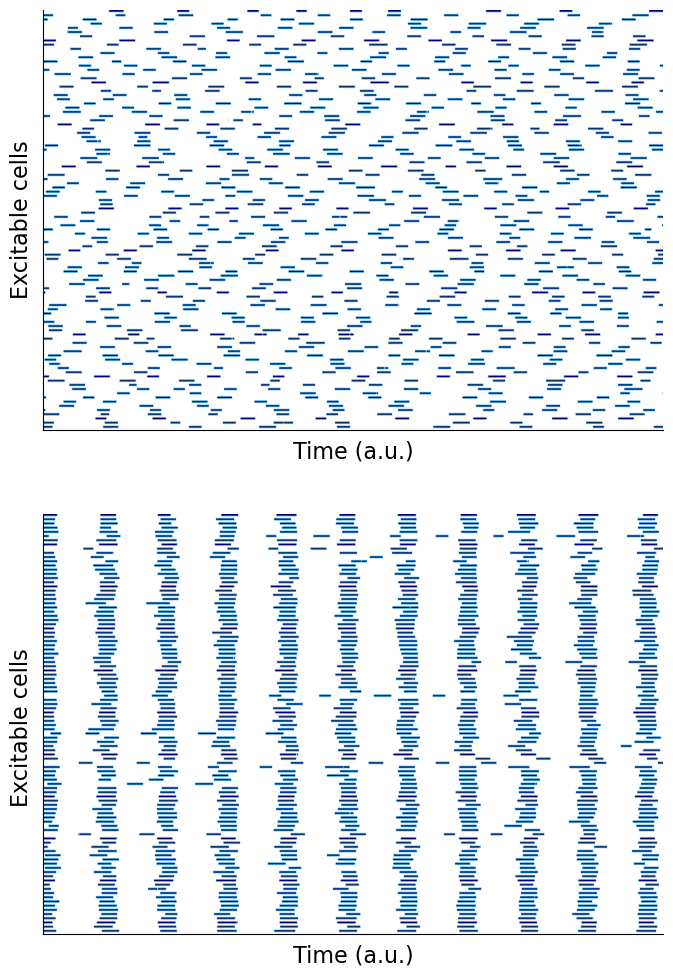

In [23]:


data1 = jnp.where(u_sol> 0.5, 1, 0)

data2 = jnp.where(u_sol1> 0.5, 1, 0)
data1=data1[1000:,39900:].T
data2=data2[1000:,900:].T
# Add blank rows between binary rows for data1
N1, T1 = data1.shape
gap1 = 1  # Gap size (number of blank rows)
data1_with_blanks = np.zeros((N1 * (gap1 + 1), T1))
for i in range(N1):
    data1_with_blanks[i * (gap1 + 1), :] = data1[i, :]

# Add blank rows between binary rows for data2
N2, T2 = data2.shape

gap2 = 1  # Gap size (number of blank rows)
data2_with_blanks = np.zeros((N2 * (gap2 + 1), T2))
for i in range(N2):
    data2_with_blanks[i * (gap2 + 1), :] = data2[i, :]

# Create a custom colormap (transparent for 0, dark blue for 1)
cmap = plt.cm.Blues
cmap = cmap(np.arange(cmap.N))
cmap[0, -1] = 0  # Set the alpha value of the first color (for 0) to 0 (fully transparent)
cmap[-1, :-1] = [0, 0, 0.5]  # Set the color for 1 to dark blue
cmap = plt.matplotlib.colors.ListedColormap(cmap)


# Plot the data
plt.figure(figsize=(8, 12), facecolor='none')
# Plot data2
plt.subplot(2, 1, 1)
plt.imshow(data2_with_blanks, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.ylabel("Excitable cells", fontsize=16)
plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)


# Plot data1
plt.subplot(2, 1, 2)
plt.imshow(data1_with_blanks, cmap=cmap, vmin=0, vmax=1, aspect='auto')
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.ylabel("Excitable cells ", fontsize=16)
plt.xlabel("Time (a.u.)", fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)
